In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow
import datasets
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import requests # For downloading files
import io # For reading downloaded content
from datasets import Dataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Baseline model 학습 결과
학습 퍼포먼스:
     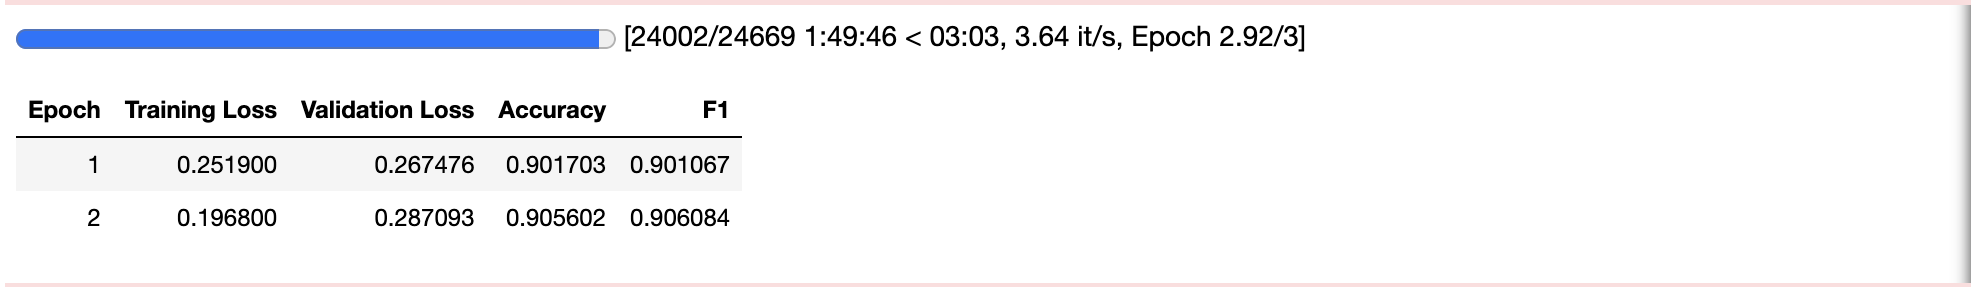
evaluation 결과:
     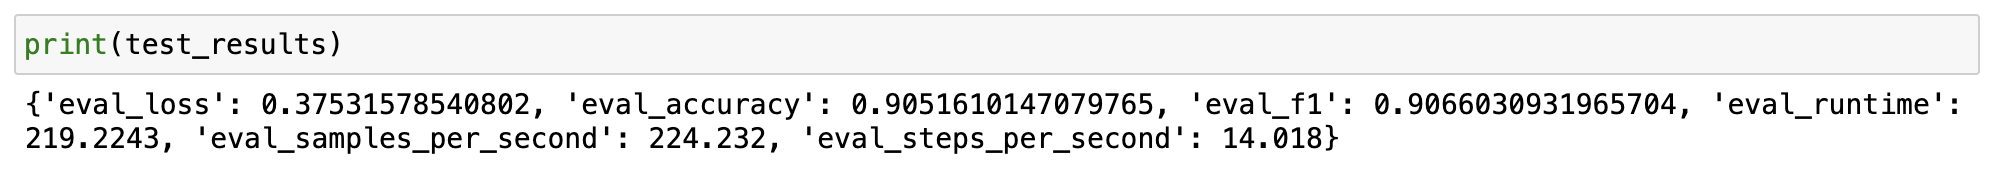
     
## 실험 개요
Baseline 모델에 bucketing과 dynamic padding을 적용했을 때, 성능 개선이 되는지 확인해본다.  
Data Collator를 정의한 부분과 TrainingArguments에서 `group_by_length=True`를 추가한 부분을 제외한 모델 구조는 baseline과 동일하다.

In [2]:
# --- Helper function to download files ---
def download_file(url, local_filename):
    """Downloads a file from a URL to a local path."""
    print(f"Downloading {url} to {local_filename}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors
        with open(local_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return False
    return True

# --- Dataset paths ---
train_file_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt"
test_file_url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
train_file_path = "ratings_train.txt"
test_file_path = "ratings_test.txt"

# Download if files don't exist
if not os.path.exists(train_file_path):
    download_file(train_file_url, train_file_path)
if not os.path.exists(test_file_path):
    download_file(test_file_url, test_file_path)

In [3]:
# --- 위에서 가져온 txt 파일을 pandas dataframe으로 변환 ---
# Read the tab-separated value files into pandas DataFrames
original_train_df = pd.read_csv(train_file_path, sep='\t', quoting=3) # quoting=3 ignores double quotes
test_df = pd.read_csv(test_file_path, sep='\t', quoting=3)
print("Datasets loaded successfully.")
print("\nTraining data sample:")
print(original_train_df.head())
print(f"\nTraining data shape: {original_train_df.shape}")
print("\nTest data sample:")
print(test_df.head())
print(f"\nTest data shape: {test_df.shape}")


Datasets loaded successfully.

Training data sample:
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

Training data shape: (150000, 3)

Test data sample:
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0

Test data shape: (50000, 3)


In [4]:
# --- Data Cleaning and Preprocessing ---
# Remove rows with missing 'document' or 'label'
original_train_df = original_train_df.dropna(subset=['document', 'label'])
test_df = test_df.dropna(subset=['document', 'label'])

# Remove duplicate entries, keeping the first occurrence
original_train_df = original_train_df.drop_duplicates(subset=['document'])
test_df = test_df.drop_duplicates(subset=['document'])

# Convert labels to integers (if they aren't already)
original_train_df['label'] = original_train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

# Ensure 'document' column is string type
original_train_df['document'] = original_train_df['document'].astype(str)
test_df['document'] = test_df['document'].astype(str)


print(f"\nShape of training data after cleaning: {original_train_df.shape}")
print(f"Shape of test data after cleaning: {test_df.shape}")
print("\nCleaned training data info:")
original_train_df.info()
print("\nCleaned test data info:")
test_df.info()


Shape of training data after cleaning: (146182, 3)
Shape of test data after cleaning: (49157, 3)

Cleaned training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB

Cleaned test data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [5]:
train_df, val_df = train_test_split(
    original_train_df,
    test_size=0.1,
    random_state=42,
    stratify=original_train_df['label']
)

In [6]:
# Pandas DataFrame -> Dict로 Dataset datatype 변환
train_dataset = train_df.to_dict('list')
val_dataset = val_df.to_dict('list')
test_dataset = test_df.to_dict('list')

# Dict -> HuggingFace Dataset로 Dataset datatype 변환
train_dataset = Dataset.from_dict(train_dataset)
val_dataset = Dataset.from_dict(val_dataset)
test_dataset = Dataset.from_dict(test_dataset)


In [7]:
# Extract documents and labels
train_texts = train_df['document'].tolist()
train_labels = train_df['label'].tolist()
val_texts = val_df['document'].tolist()
val_labels = val_df['label'].tolist()
test_texts = test_df['document'].tolist()
test_labels = test_df['label'].tolist()

print(f"\nNumber of training reviews: {len(train_texts)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation reviews: {len(val_texts)}")
print(f"Number of validation labels: {len(val_labels)}")
print(f"Number of test reviews: {len(test_texts)}")
print(f"Number of test labels: {len(test_labels)}")


Number of training reviews: 131563
Number of training labels: 131563
Number of validation reviews: 14619
Number of validation labels: 14619
Number of test reviews: 49157
Number of test labels: 49157


## 2. klue/bert-base model 및 tokenizer 불러오기

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [9]:
train_dataset['document'][0]

'가볍게 보기 좋음. 이지훈 귀여움'

Calculating token lengths for documents in original_train_df...
Calculated token lengths for 146182 documents.


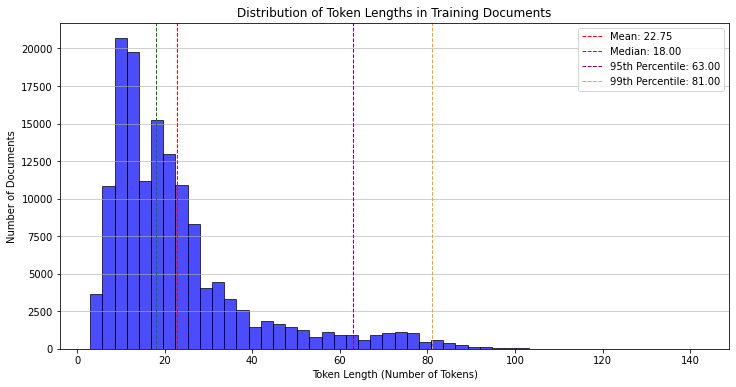

Average token length: 22.75
Median token length: 18.00
Maximum observed token length: 142.00
90th percentile token length: 45.00
95th percentile token length: 63.00
99th percentile token length: 81.00

Based on the 95th percentile, a suggested MAX_LENGTH could be around 63.
Or, aligning to a multiple of 32 (and <=512): 64


In [10]:
# 데이터 분포 탐색
import matplotlib.pyplot as plt

if 'original_train_df' in locals() and not original_train_df.empty:
    print("Calculating token lengths for documents in original_train_df...")
    # Get the 'document' column, ensuring it's a list of strings
    documents_to_analyze = original_train_df['document'].astype(str).tolist()

    # Tokenize documents without padding or truncation to get actual lengths
    # The tokenizer should be the one you loaded (e.g., AutoTokenizer.from_pretrained("klue/bert-base"))
    token_lengths = []
    for doc in documents_to_analyze:
        # encode() returns a list of token IDs. The length of this list is the number of tokens.
        # We don't want special tokens ([CLS], [SEP]) here if we are purely analyzing content length,
        # but for max_len decision, including them is more realistic as they will be part of the input.
        ids = tokenizer.encode(doc, add_special_tokens=True) # Set add_special_tokens=True is usually better for max_len decision
        token_lengths.append(len(ids))

    print(f"Calculated token lengths for {len(token_lengths)} documents.")

    # --- Plotting the distribution ---
    plt.figure(figsize=(12, 6))
    plt.hist(token_lengths, bins=50, alpha=0.7, color='blue', edgecolor='black') # You can adjust bins
    plt.title('Distribution of Token Lengths in Training Documents')
    plt.xlabel('Token Length (Number of Tokens)')
    plt.ylabel('Number of Documents')
    plt.grid(axis='y', alpha=0.75)

    # Add some descriptive statistics to the plot or print them
    avg_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    max_obs_len = np.max(token_lengths)
    # Quantiles can be very helpful
    percentile_90 = np.percentile(token_lengths, 90)
    percentile_95 = np.percentile(token_lengths, 95)
    percentile_99 = np.percentile(token_lengths, 99)

    plt.axvline(avg_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {avg_len:.2f}')
    plt.axvline(median_len, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_len:.2f}')
    plt.axvline(percentile_95, color='purple', linestyle='dashed', linewidth=1, label=f'95th Percentile: {percentile_95:.2f}')
    plt.axvline(percentile_99, color='orange', linestyle='dashed', linewidth=1, label=f'99th Percentile: {percentile_99:.2f}')

    plt.legend()
    plt.show()

    print(f"Average token length: {avg_len:.2f}")
    print(f"Median token length: {median_len:.2f}")
    print(f"Maximum observed token length: {max_obs_len:.2f}")
    print(f"90th percentile token length: {percentile_90:.2f}")
    print(f"95th percentile token length: {percentile_95:.2f}")
    print(f"99th percentile token length: {percentile_99:.2f}")

    suggested_max_len = min(512, int(np.ceil(percentile_95 / 32.0)) * 32) # Common practice to align with powers of 2 or multiples like 32, 64
                                                                        # And not exceeding model's max (often 512 for BERT)
    print(f"\nBased on the 95th percentile, a suggested MAX_LENGTH could be around {percentile_95:.0f}.")
    print(f"Or, aligning to a multiple of 32 (and <=512): {suggested_max_len}")


else:
    print("Error: 'original_train_df' not found or is empty. Please ensure it's loaded and processed correctly.")

위 토큰 길이 분포 그래프에서 확인했듯 90% percentile인 63으로 max_length를 설정해준다.

In [11]:
def tokenize_fn(batch):
    return tokenizer(
        batch['document'],
        truncation=True,
        max_length=63,
        padding=False, # # ADDED: DataCollator 정의해줌.
        return_token_type_ids=True,
    )

In [12]:
train_tokenized_dataset = train_dataset.map(tokenize_fn, batched=True)
val_tokenized_dataset = val_dataset.map(tokenize_fn, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_fn, batched=True)

  0%|          | 0/132 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [13]:
train_tokenized_dataset

Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
    num_rows: 131563
})

In [14]:
print(len(train_tokenized_dataset['input_ids'][0]))
train_tokenized_dataset['input_ids'][0]

12


[2, 6758, 2318, 1160, 2015, 1560, 2053, 18, 9353, 2034, 29227, 3]

In [15]:
# ADDED: Bucketing과 Dynamic Padding을 위해 DataCollator 정의해줌.
# 여기서 정의된 DataCollator는 이후 Trainer 정의할 때 입력됨.
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest')

## 3. 모델 학습

In [16]:
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/node_24'

training_arguments = TrainingArguments(
    output_dir,
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    group_by_length=True, # ADDED: Bucketing과 Dynamic Padding을 위해 group_by_length=True.
    fp16=True             # ADDED: 32bit 대신 16bit를 섞어서 사용하여 학습속도를 높이는 설정.
)

In [17]:
from datasets import load_metric
import numpy as np

# Load metrics separately
accuracy_metric = load_metric('accuracy')
f1_metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, actual_labels = eval_pred # eval_pred is a tuple of (logits, labels)
    predicted_labels = np.argmax(logits, axis=1)

    acc_result = accuracy_metric.compute(predictions=predicted_labels, references=actual_labels)
    # For binary classification, specify average='binary' for F1 score
    f1_result = f1_metric.compute(predictions=predicted_labels, references=actual_labels, average="binary")

    return {
        "accuracy": acc_result["accuracy"],
        "f1": f1_result["f1"], # The Hugging Face F1 metric returns a dict with "f1" as key
    }

In [18]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_tokenized_dataset,
    eval_dataset=val_tokenized_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator # ADDED: Trainer에 Data Collator 추가
)
trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 131563
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 24669


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.249800,0.244147,0.904303,0.904027
2,0.186200,0.276314,0.909501,0.909377
3,0.112200,0.364915,0.907449,0.907777


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to /aiffel/aiffel/node_24/checkpoint-500
Configuration saved in /aiffel/aiffel/node_24/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/node_24/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/node_24/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/node_24/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /aiffel/aiffel/node_24/checkpoint-1000
Configuration saved in /aiffel/aiffel/node_24/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/node_24/checkpoin

TrainOutput(global_step=24669, training_loss=0.20096509123878767, metrics={'train_runtime': 4056.4846, 'train_samples_per_second': 97.298, 'train_steps_per_second': 6.081, 'total_flos': 4604575538216460.0, 'train_loss': 0.20096509123878767, 'epoch': 3.0})

In [19]:
# 학습 도중 커널이 끊겨서 저장된 checkpoint로 evaluate.
model = AutoModelForSequenceClassification.from_pretrained('baseline_checkpoints/checkpoint-24000')
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_tokenized_dataset,
    eval_dataset=val_tokenized_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

test_results = trainer.evaluate(test_tokenized_dataset)

loading configuration file baseline_checkpoints/checkpoint-24000/config.json
Model config BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file baseline_checkpoints/checkpoint-24000/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassific

In [20]:
print(test_results)

{'eval_loss': 0.37531575560569763, 'eval_accuracy': 0.9051610147079765, 'eval_f1': 0.9066030931965704, 'eval_runtime': 215.259, 'eval_samples_per_second': 228.362, 'eval_steps_per_second': 14.276}


## 회고
### Baseline 모델과의 비교
Baseline 모델과 비교했을 때, eval_accuracy는 정확히 똑같은 점수(0.9051610147079765)를 보여줬지만, 학습 시간이 기존 1h 50m에서 1h 7m으로 상당히 단축되었다.
학습시간 단축에 기여한 부분은 두 가지가 있다:  
1. Bucketing과 Dynamic padding을 이용하여 불필요한 padding을 줄였다.
2. `TrainingArguments`에서 `fp16` 파라미터를 True로 설정하여 32bit 연산을 중간 중간 16bit 연산으로 바꿔서 연산량 감축  

시간이 더 있었더라면 위의 두 가지 통제변인에 대해 각각이 학습시간 단축에 미치는 영향을 분석할 수 있었을 텐데 못한 점이 아쉽다.

### 느낀 점
지금껏 잘해봐야 0.6 수준의 eval accuracy를 보며 낙담하다가 이전에 보지 못했던 0.9라는 eval accuracy를 보며 효능감을 느꼈던 프로젝트였다.  
Pretrained 모델을 사용하는 것의 힘을 느꼈다.